In [1]:
# Process dark count data from the Single-Photon Counting Module (SPCM)
# Grant Kirchhoff
# Last updated: 11.23.2022

import numpy as np
import pandas as pd
import time
import pickle
import matplotlib.pyplot as plt
import os
import sys

cwd = os.getcwd()
sys.path.append(os.getcwd()+'\..\library')

from load_ARSENL_data import load_INPHAMIS_data

In [2]:
start = time.time()

# Constants
c = 299792458  # [m/s] Speed of light

# Parameters
create_csv = 0  # Set true to generate a .csv from .ARSENL data
load_data = True  # Set true to load data into a DataFrame and serialize into a pickle object
picklename = 'spcm_dc_ch0'

data_dir = r'C:\Users\Grant\OneDrive - UCB-O365\ARSENL\Experiments\SPCM_Dark_Counts\SPCM_DC'
fname = r'\Dev_0_-_2022-10-27_16.12.31_SPCM_DC.ARSENL'

# Load INPHAMIS .ARSENL data if not yet serialized
if load_data:
    df = load_INPHAMIS_data(data_dir, fname, picklename, create_csv)

Elapsed time (read pd): 1.1907248497009277 sec


In [3]:
# Unpickle the data to DataFrame object
infile = open('{}/{}'.format(data_dir, picklename), 'rb')
df = pickle.load(infile)
infile.close()

In [4]:
detect = df.loc[(df['overflow'] == 0) & (df['channel'] == 0)]  # Return data for detection event ("overflow","channel" = 0,0)
sync = df.loc[(df['overflow'] == 1) & (df['channel'] == 0)]
rollover = df.loc[(df['overflow'] == 1) & (df['channel'] == 63)]
n_shots = len(sync)
n_rollover = len(rollover)

In [5]:
dcount = detect  # each "detection" event is a dark count from the SPCM

dcount_idx = np.array(dcount.index)  # Indices of dark count events
sync_dcount_idx = np.array(dcount_idx) - 1  # Extract index immediately prior to dark count event to match with laser pulse
sync_dcount = df.loc[sync_dcount_idx]  # Laser pulse event prior to dark count event
rollover_idx = np.array(rollover.index)
# Note: I don't know if there is any significance to tracking the laser pulse that occurs prior to each dark count event but it might be useful to have...

dcount_time = dcount['dtime'].to_numpy()
sync_dcount_time = sync_dcount['dtime'].to_numpy()

Number of rollovers per dark count event: 
[ 2.  2. 28. ...  2.  4.  1.]


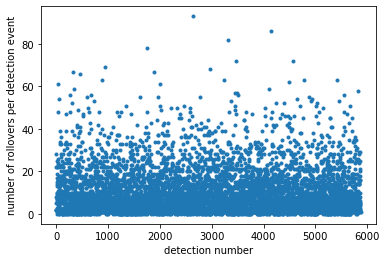

In [6]:
# print(dcount_idx)
# print(rollover_idx[3])

# Function that uses rolloevers to convert detection time stamps from relative to global
prev_num_rolls = 0
track_rolls = np.zeros(len(dcount_idx))
for i in range(len(dcount_idx)):
    prev_roll_idx = np.argmin(np.abs(dcount_idx[i] - rollover_idx))
    if rollover_idx[prev_roll_idx] > dcount_idx[i]:
        prev_roll_idx -= 1
    num_rolls = prev_roll_idx + 1 - prev_num_rolls
    prev_num_rolls += num_rolls
    
    track_rolls[i] = num_rolls
    
print('Number of rollovers per dark count event: \n{}'.format(track_rolls))

plt.plot(track_rolls, '.')
plt.xlabel('detection number')
plt.ylabel('number of rollovers per detection event')
plt.show()


In [7]:
roll_cnts = 2**25
total_rolls_before_dcount = np.cumsum(track_rolls)
total_cnts_before_dcount = roll_cnts * total_rolls_before_dcount
dcount_cnts = dcount_time + total_cnts_before_dcount

In [8]:
spec_dcr = np.array([43, 500])  # [Hz] [Measured, Max]
spec_dc_period = 1 / spec_dcr

spec_deadtime = 29.1e-9  # [s]

In [9]:
dcount_global_time = dcount_cnts * 25e-12 # [s] convert from clock count to s
dcount_inter_time = np.diff(dcount_global_time)

In [10]:
# dcount_inter_time = dcount_inter_time[np.where(dcount_inter_time<1e-4)]

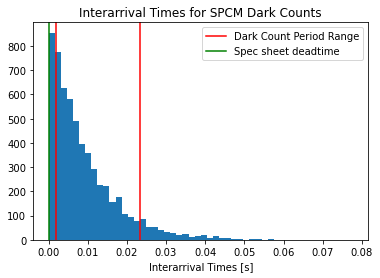

In [21]:
use_log = False

num_bins = 50
lin_bins = np.linspace(np.min(dcount_inter_time), np.max(dcount_inter_time), num_bins+1)
log_bins = np.logspace(np.log10(np.min(dcount_inter_time)), np.log10(np.max(dcount_inter_time)), num_bins+1)

fig = plt.figure()
ax = fig.add_subplot(111)
if use_log:
    ax.hist(dcount_inter_time, log_bins)
    ax.set_xscale('log')
else:
    ax.hist(dcount_inter_time, lin_bins)
ax.set_xlabel('Interarrival Times [s]')
ax.set_title('Interarrival Times for SPCM Dark Counts')
# ax.set_xlim([1e-8, 1e-3])
plt.axvline(x=spec_dc_period[0], color='r', label='Dark Count Period Range')
plt.axvline(x=spec_dc_period[1], color='r')
plt.axvline(x=spec_deadtime, color='g', label="Spec sheet deadtime")
plt.legend()
plt.show()

Note: (11/30/22) True Poisson Point Process interarrival time distribution function should be exponential decay, starting from the smallest time interval possible (i.e., the deadtime). We aren't seeing that here. Instead it looks Gamma function like. Maybe this indicates we can't treat dark counts as a true Poisson point process?

Maybe hit up Xiaoli to ask about this?

total average dark-count rate: 109.62 Hz
spec sheet quoted measured dark-count rate: 43 Hz


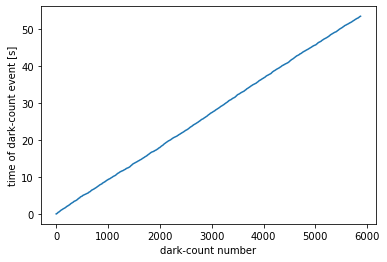

In [21]:
avg_dcount_rate = 1/(dcount_global_time[-1]/len(dcount_global_time))
print('total average dark-count rate: {:.2f} Hz'.format(avg_dcount_rate))
print('spec sheet quoted measured dark-count rate: {} Hz'.format(spec_dcr[0]))

plt.plot(dcount_global_time)
plt.xlabel('dark-count number')
plt.ylabel('time of dark-count event [s]')
plt.show()

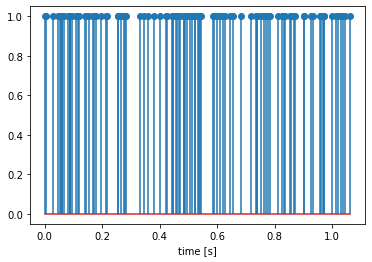

In [28]:
include = 100


plt.stem(dcount_global_time[:include], np.ones(len(dcount_global_time[:include])))
plt.xlabel('time [s]')
plt.show()

In [17]:
# flight_time = (dcount_time - sync_dcount_time) * 25  # [ps] Time is in segments of 25 ps
# distance = flight_time / 1e12 * c / 2

In [18]:
# ### Histogram of time of flight ###
# fig = plt.figure()
# ax1 = fig.add_subplot(111)
# n, bins = np.histogram(flight_time/1e12, bins=90)
# binwidth = np.diff(bins)[0]
# N = n / binwidth / n_shots
# center = 0.5 * (bins[:-1] + bins[1:])
# ax1.bar(center, N, align='center', width=binwidth, color='b', alpha=0.75)
# ax1.set_xlabel('Time of flight [ps]')
# ax1.set_ylabel('Arrival rate [Hz]')
# ax1.set_title('Time of flight for INPHAMIS backscatter')
# plt.tight_layout()
# plt.show()